In [1]:
from google.colab import drive,output
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/datasets/stage1_train.zip -d stage1_train
!unzip drive/MyDrive/datasets/stage1_test.zip -d stage1_test
output.clear()

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,Reshape,LeakyReLU,UpSampling2D,MaxPooling2D,concatenate,Input,Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
!pip install git+https://github.com/tensorflow/examples.git
!pip install segmentation_models

output.clear()


In [4]:
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [44]:
img_h=224
img_w=224

In [45]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap='gray')
    plt.axis('off')
  plt.show()

In [46]:
train_path='stage1_train/'
test_path='stage1_test/'

In [47]:
train_id=next(os.walk(train_path))[1]
test_id=next(os.walk(test_path))[1]

In [48]:
#TRAIN DATA
X_train=np.zeros((len(train_id),img_h,img_w,3),dtype=np.uint8)
y_train=np.zeros((len(train_id),img_h,img_w,1),dtype=bool)

for n,id in tqdm(enumerate(train_id),total=len(train_id)):
  path=train_path+id
  img=load_img(path+'/images/'+id+'.png',target_size=(img_h,img_w))
  img=img_to_array(img)
  X_train[n]=(img)
  mask=np.zeros((img_h,img_w,1),dtype=bool)
  for mask_file in next(os.walk(path+'/masks/'))[2]:
    mask_=load_img(path+'/masks/'+mask_file,target_size=(img_h,img_w),color_mode='grayscale')
    mask_=img_to_array(mask_)
    mask=np.maximum(mask,mask_)
  y_train[n]=(mask)
  n+=1

#TEST DATA
X_test=np.zeros((len(test_id),img_h,img_w,3),dtype=np.uint8)

for n,id in tqdm(enumerate(test_id),total=len(test_id)):
  path=test_path+id
  img=load_img(path+'/images/'+id+'.png',target_size=(img_h,img_w))
  img=img_to_array(img)
  X_test[n]=(img)
  n+=1


100%|██████████| 65/65 [00:00<00:00, 123.26it/s]


In [49]:
t1=X_train
t2=y_train
t3=X_test

In [50]:
X_val=X_train[600:]
y_val=y_train[600:]
X_train=X_train[:600]
y_train=y_train[:600]

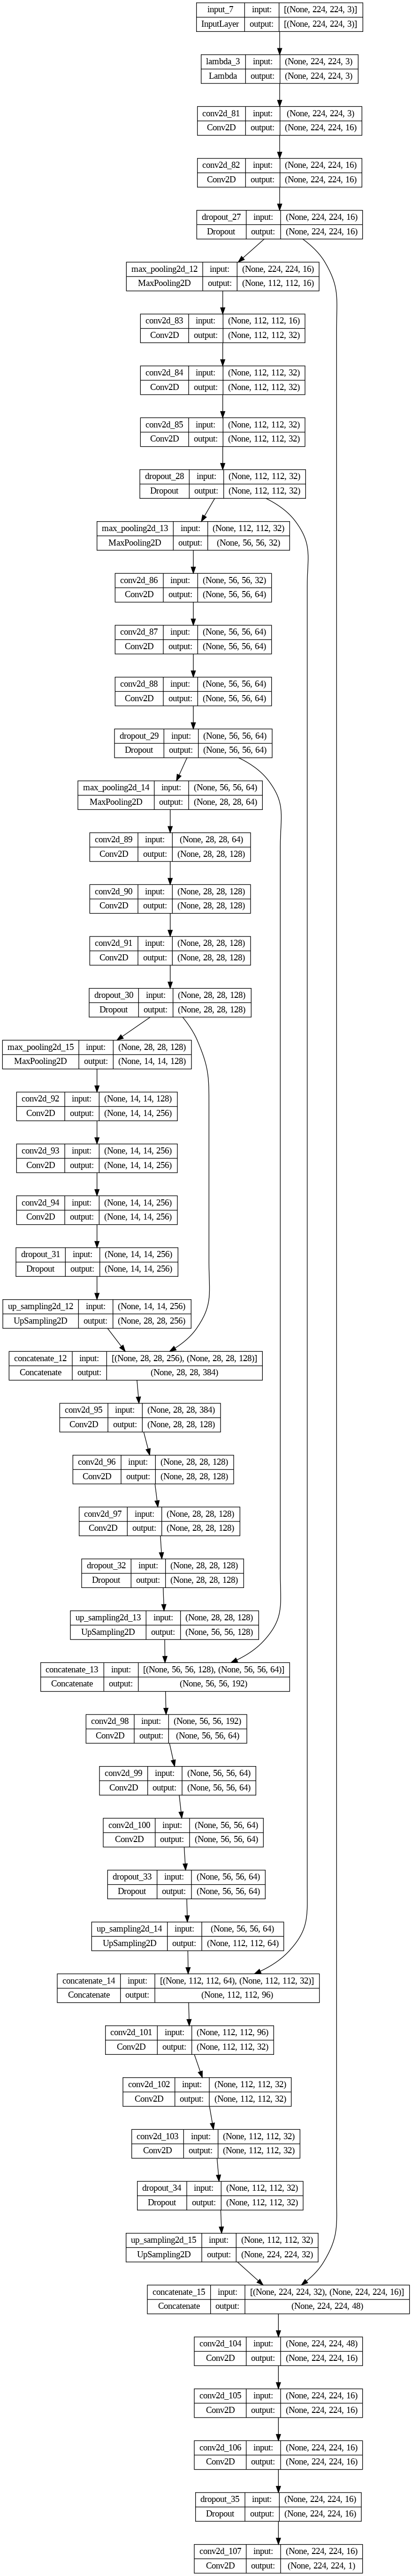

In [52]:
inputs=Input((img_h,img_w,3))
s=Lambda(lambda x:x/255)(inputs)
c1=Conv2D(16,3,padding='same',activation='relu')(s)
c1=Conv2D(16,3,padding='same',activation='relu')(c1)
c1=Dropout(0.2)(c1)
    #downsample
p1=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c1)

c2=Conv2D(32,3,padding='same',activation='relu')(p1)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Dropout(0.2)(c2)
    #downsample
p2=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c2)

c3=Conv2D(64,3,padding='same',activation='relu')(p2)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Dropout(0.2)(c3)
    #downsample
p3=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c3)

c4=Conv2D(128,3,padding='same',activation='relu')(p3)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Dropout(0.2)(c4)
    #downsample
p4=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c4)

c5=Conv2D(256,3,padding='same',activation='relu')(p4)
c5=Conv2D(256,3,padding='same',activation='relu')(c5)
c5=Conv2D(256,3,padding='same',activation='relu')(c5)
c5=Dropout(0.2)(c5)

    #upsample
u6=UpSampling2D()(c5)
u6=concatenate([u6,c4])
c6=Conv2D(128,3,padding='same',activation='relu')(u6)
c6=Conv2D(128,3,padding='same',activation='relu')(c6)
c6=Conv2D(128,3,padding='same',activation='relu')(c6)
c6=Dropout(0.2)(c6)

u7=UpSampling2D()(c6)
u7=concatenate([u7,c3])
c7=Conv2D(64,3,padding='same',activation='relu')(u7)
c7=Conv2D(64,3,padding='same',activation='relu')(c7)
c7=Conv2D(64,3,padding='same',activation='relu')(c7)
c7=Dropout(0.2)(c7)

u8=UpSampling2D()(c7)
u8=concatenate([u8,c2])
c8=Conv2D(32,3,padding='same',activation='relu')(u8)
c8=Conv2D(32,3,padding='same',activation='relu')(c8)
c8=Conv2D(32,3,padding='same',activation='relu')(c8)
c8=Dropout(0.2)(c8)

u9=UpSampling2D()(c8)
u9=concatenate([u9,c1])
c9=Conv2D(16,3,padding='same',activation='relu')(u9)
c9=Conv2D(16,3,padding='same',activation='relu')(c9)
c9=Conv2D(16,3,padding='same',activation='relu')(c9)
c9=Dropout(0.2)(c9)

outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)
    # Flatten(),
    # Dense(1,activation='softmax')

model=Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='binary_crossentropy',metrics=['accuracy'])

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_accuracy')
lrp=ReduceLROnPlateau(monitor="iou_score", factor=0.1, patience=2)
es=EarlyStopping(patience=2,monitor='iou_score')
call=[mp]

model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call
)

Epoch 1/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0442 - accuracy: 0.9829 - val_loss: 0.0635 - val_accuracy: 0.9772
Epoch 2/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0380 - accuracy: 0.9847 - val_loss: 0.0650 - val_accuracy: 0.9780
Epoch 3/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0364 - accuracy: 0.9853 - val_loss: 0.0657 - val_accuracy: 0.9784
Epoch 4/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0363 - accuracy: 0.9853 - val_loss: 0.0653 - val_accuracy: 0.9785
Epoch 5/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0360 - accuracy: 0.9854 - val_loss: 0.0668 - val_accuracy: 0.9781
Epoch 6/10
600/600 [==============================] - 10s 17ms/step - loss: 0.0358 - accuracy: 0.9855 - val_loss: 0.0650 - val_accuracy: 0.9786
Epoch 7/10
600/600 [==============================] - 9s 16ms/step - loss: 0.0356 - accuracy: 0.9856 - val_loss: 0.0634 - val_accuracy: 

1/1 [==============================] - 0s 26ms/step
(1, 224, 224, 1)


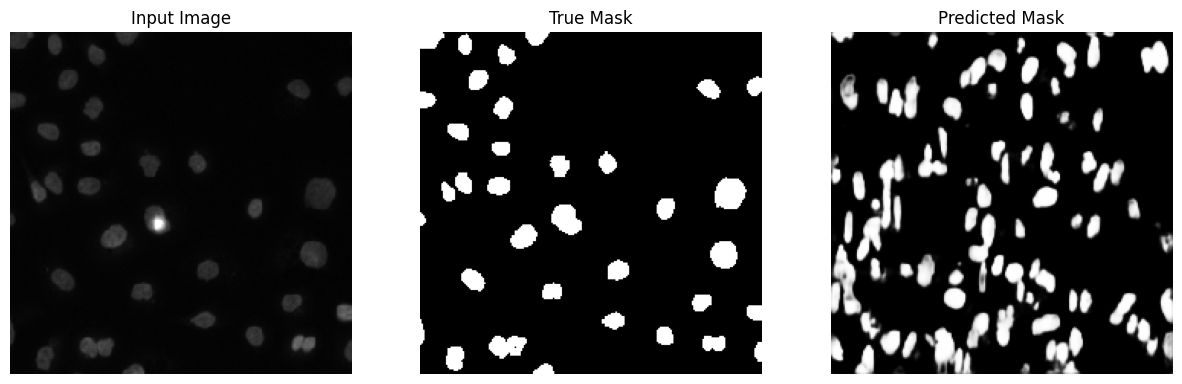

In [66]:
kk=20
p=X_test[kk]
p=p.reshape(( 1,p.shape[0], p.shape[1], p.shape[2]))
pred=model.predict(p)
# pred=XX
print(pred.shape)
pred=pred.reshape((pred.shape[1],pred.shape[2],pred.shape[3]))
display([X_train[kk],y_train[kk],pred])

In [42]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb4'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, input_shape=(img_h,img_w,3),encoder_weights='imagenet',activation='sigmoid')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['binary_accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.IOUScore(),sm.metrics.FScore()])# tf.keras.utils.plot_model(model, show_shapes=True)

In [35]:
# model.summary()

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_iou_score')
lrp=ReduceLROnPlateau(monitor="iou_score", factor=0.1, patience=2)
# es=EarlyStopping(patience=2,monitor='iou_score')
call=[lrp]

model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    batch_size=1,
    steps_per_epoch=100,
    epochs=10,
    callbacks=[mp]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.3909 - binary_accuracy: 0.8791 - recall: 0.4675 - precision: 0.5733 - auc: 0.8048 - iou_score: 0.1803 - f1-score: 0.2903

100/100 [==============================] - 13s 125ms/step - loss: 0.3909 - binary_accuracy: 0.8791 - recall: 0.4675 - precision: 0.5733 - auc: 0.8048 - iou_score: 0.1803 - f1-score: 0.2903 - val_loss: 0.5379 - val_binary_accuracy: 0.7632 - val_recall: 0.4852 - val_precision: 0.2992 - val_auc: 0.7728 - val_iou_score: 0.1739 - val_f1-score: 0.2886
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2472 - binary_accuracy: 0.9363 - recall: 0.7125 - precision: 0.7977 - auc: 0.9533 - iou_score: 0.2890 - f1-score: 0.4274

100/100 [==============================] - 10s 96ms/step - loss: 0.2472 - binary_accuracy: 0.9363 - recall: 0.7125 - precision: 0.7977 - auc: 0.9533 - iou_score: 0.2890 - f1-score: 0.4274 - val_loss: 0.4549 - val_binary_accuracy: 0.7577 - val_recall: 0.3734 - val_precision: 0.2600 - val_auc: 0.8119 - val_iou_score: 0.1858 - val_f1-score: 0.3075
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2038 - binary_accuracy: 0.9447 - recall: 0.7521 - precision: 0.8418 - auc: 0.9631 - iou_score: 0.3400 - f1-score: 0.4816

100/100 [==============================] - 9s 90ms/step - loss: 0.2038 - binary_accuracy: 0.9447 - recall: 0.7521 - precision: 0.8418 - auc: 0.9631 - iou_score: 0.3400 - f1-score: 0.4816 - val_loss: 0.4135 - val_binary_accuracy: 0.7794 - val_recall: 0.2517 - val_precision: 0.2417 - val_auc: 0.8108 - val_iou_score: 0.1502 - val_f1-score: 0.2539
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.1671 - binary_accuracy: 0.9530 - recall: 0.8052 - precision: 0.8738 - auc: 0.9768 - iou_score: 0.4070 - f1-score: 0.5549

100/100 [==============================] - 10s 95ms/step - loss: 0.1671 - binary_accuracy: 0.9530 - recall: 0.8052 - precision: 0.8738 - auc: 0.9768 - iou_score: 0.4070 - f1-score: 0.5549 - val_loss: 0.4135 - val_binary_accuracy: 0.7744 - val_recall: 0.2809 - val_precision: 0.2475 - val_auc: 0.8177 - val_iou_score: 0.1737 - val_f1-score: 0.2895
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.1473 - binary_accuracy: 0.9572 - recall: 0.8100 - precision: 0.8674 - auc: 0.9807 - iou_score: 0.4079 - f1-score: 0.5528

100/100 [==============================] - 10s 102ms/step - loss: 0.1473 - binary_accuracy: 0.9572 - recall: 0.8100 - precision: 0.8674 - auc: 0.9807 - iou_score: 0.4079 - f1-score: 0.5528 - val_loss: 0.4022 - val_binary_accuracy: 0.7735 - val_recall: 0.3329 - val_precision: 0.2674 - val_auc: 0.8334 - val_iou_score: 0.2079 - val_f1-score: 0.3380
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 0.1309 - binary_accuracy: 0.9619 - recall: 0.8291 - precision: 0.8708 - auc: 0.9811 - iou_score: 0.4331 - f1-score: 0.5769

100/100 [==============================] - 9s 94ms/step - loss: 0.1309 - binary_accuracy: 0.9619 - recall: 0.8291 - precision: 0.8708 - auc: 0.9811 - iou_score: 0.4331 - f1-score: 0.5769 - val_loss: 0.4352 - val_binary_accuracy: 0.7717 - val_recall: 0.2646 - val_precision: 0.2361 - val_auc: 0.8303 - val_iou_score: 0.1845 - val_f1-score: 0.3060
Epoch 7/10
100/100 [==============================] - ETA: 0s - loss: 0.1324 - binary_accuracy: 0.9579 - recall: 0.7981 - precision: 0.8945 - auc: 0.9787 - iou_score: 0.4509 - f1-score: 0.5989

100/100 [==============================] - 9s 91ms/step - loss: 0.1324 - binary_accuracy: 0.9579 - recall: 0.7981 - precision: 0.8945 - auc: 0.9787 - iou_score: 0.4509 - f1-score: 0.5989 - val_loss: 0.5084 - val_binary_accuracy: 0.7692 - val_recall: 0.2865 - val_precision: 0.2424 - val_auc: 0.8343 - val_iou_score: 0.2037 - val_f1-score: 0.3324
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9703 - recall: 0.8445 - precision: 0.9045 - auc: 0.9876 - iou_score: 0.4849 - f1-score: 0.6369

100/100 [==============================] - 10s 102ms/step - loss: 0.1012 - binary_accuracy: 0.9703 - recall: 0.8445 - precision: 0.9045 - auc: 0.9876 - iou_score: 0.4849 - f1-score: 0.6369 - val_loss: 0.5423 - val_binary_accuracy: 0.7543 - val_recall: 0.2431 - val_precision: 0.2027 - val_auc: 0.7924 - val_iou_score: 0.1382 - val_f1-score: 0.2363
Epoch 9/10
100/100 [==============================] - ETA: 0s - loss: 0.1215 - binary_accuracy: 0.9583 - recall: 0.8441 - precision: 0.8958 - auc: 0.9853 - iou_score: 0.5460 - f1-score: 0.6877

100/100 [==============================] - 10s 105ms/step - loss: 0.1215 - binary_accuracy: 0.9583 - recall: 0.8441 - precision: 0.8958 - auc: 0.9853 - iou_score: 0.5460 - f1-score: 0.6877 - val_loss: 0.4111 - val_binary_accuracy: 0.7720 - val_recall: 0.2561 - val_precision: 0.2324 - val_auc: 0.8306 - val_iou_score: 0.1796 - val_f1-score: 0.2972
Epoch 10/10
100/100 [==============================] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9671 - recall: 0.8690 - precision: 0.8768 - auc: 0.9882 - iou_score: 0.5254 - f1-score: 0.6658

100/100 [==============================] - 9s 86ms/step - loss: 0.1012 - binary_accuracy: 0.9671 - recall: 0.8690 - precision: 0.8768 - auc: 0.9882 - iou_score: 0.5254 - f1-score: 0.6658 - val_loss: 0.4209 - val_binary_accuracy: 0.7820 - val_recall: 0.2293 - val_precision: 0.2344 - val_auc: 0.8154 - val_iou_score: 0.1472 - val_f1-score: 0.2481


1/1 [==============================] - 0s 33ms/step
(1, 128, 128, 1)


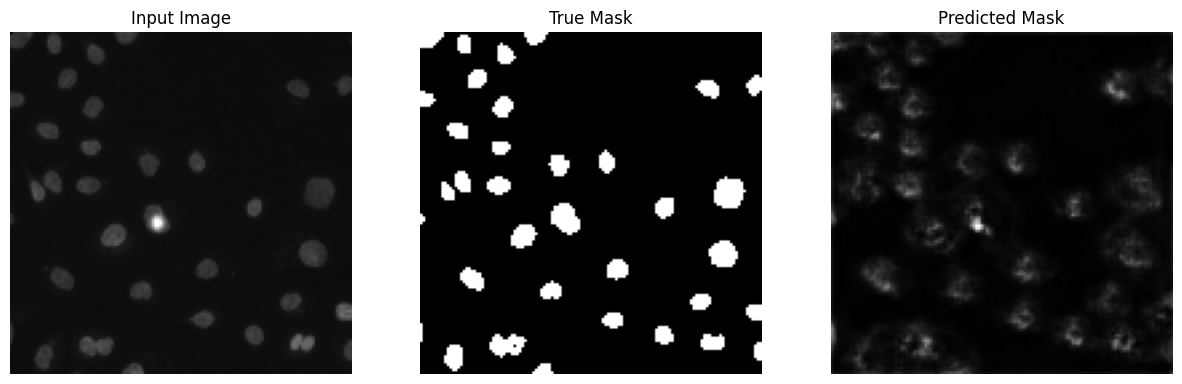

In [34]:
kk=20
p=X_train[kk]
p=p.reshape(( 1,p.shape[0], p.shape[1], p.shape[2]))
pred=model.predict(p)
# pred=XX
print(pred.shape)
pred=pred.reshape((pred.shape[1],pred.shape[2],pred.shape[3]))
display([X_train[kk],y_train[kk],pred])